# Trabajo Final

In [1]:
import warnings
from copy import deepcopy

import matplotlib.pyplot as plt
import medmnist
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from medmnist import INFO, Evaluator
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from torchvision import models
from tqdm import tqdm

warnings.simplefilter(action="ignore", category=FutureWarning)

pl.seed_everything(1)


data_flag = "organsmnist"
download = True

info = INFO[data_flag]
task = info["task"]
n_channels = info["n_channels"]
n_classes = len(info["label"])

DataClass = getattr(medmnist, info["python_class"])

Global seed set to 1


# Creando los datasets
Ahora procederemos a crear los datasets con las imágenes de training y de test. Aquí por simplicidad no utilizaremos la partición de validación, pero recordar que siempre se debe contar con una partición de validación para la selección de hiperparámetros y de modelo.

In [2]:
# Tamaño del batch de entrenamiento que será utilizado al generar los dataloaders
BATCH_SIZE = 128

# Transformaciones que serán utilizadas para normalizar las imagenes
data_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])]
)

# Creo los datasets
train_dataset = DataClass(split="train", transform=data_transform, download=download)
val_dataset = DataClass(split="val", transform=data_transform, download=download)
test_dataset = DataClass(split="test", transform=data_transform, download=download)

# Dataset que será utilizado solo para vbisualización (no incluye las transformaciones)
visual_dataset = DataClass(split="train", download=download)

# Encapsulo los datasets en un dataloader
train_loader = data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
val_loader = data.DataLoader(
    dataset=val_dataset, batch_size=2 * BATCH_SIZE, shuffle=False
)
test_loader = data.DataLoader(
    dataset=test_dataset, batch_size=2 * BATCH_SIZE, shuffle=False
)

Using downloaded and verified file: /clusteruy/home/cmarino/.medmnist/organsmnist.npz
Using downloaded and verified file: /clusteruy/home/cmarino/.medmnist/organsmnist.npz
Using downloaded and verified file: /clusteruy/home/cmarino/.medmnist/organsmnist.npz
Using downloaded and verified file: /clusteruy/home/cmarino/.medmnist/organsmnist.npz


In [3]:
def get_counts_labels(loader):
    labels = []
    for _, label in loader:
        labels.extend(list(label[:, 0].numpy()))
    mapping = {int(k): v.capitalize() for (k, v) in info["label"].items()}
    mapping = np.vectorize(mapping.get)
    labels = mapping(labels)
    return pd.DataFrame(pd.Series(labels).value_counts())


counts_train = get_counts_labels(train_loader)
counts_val = get_counts_labels(val_loader)
counts_test = get_counts_labels(test_loader)

In [4]:
df = pd.concat([counts_train, counts_val, counts_test], axis=1)
df.columns = ["#Train", "#Val", "#Test"]
# df.index = df.index.rename("Organo")
df

,#Train,#Val,#Test
Liver,3464,491,2078
Pancreas,2004,280,1343
Spleen,1556,213,968
Bladder,1148,188,811
Kidney-left,1132,140,704
Kidney-right,1119,159,693
Lung-right,803,275,439
Lung-left,741,261,397
Heart,721,246,510
Femur-left,637,104,439


In [5]:
info["label"]

{'0': 'bladder',
 '1': 'femur-left',
 '2': 'femur-right',
 '3': 'heart',
 '4': 'kidney-left',
 '5': 'kidney-right',
 '6': 'liver',
 '7': 'lung-left',
 '8': 'lung-right',
 '9': 'pancreas',
 '10': 'spleen'}

# Visualizando las imágenes

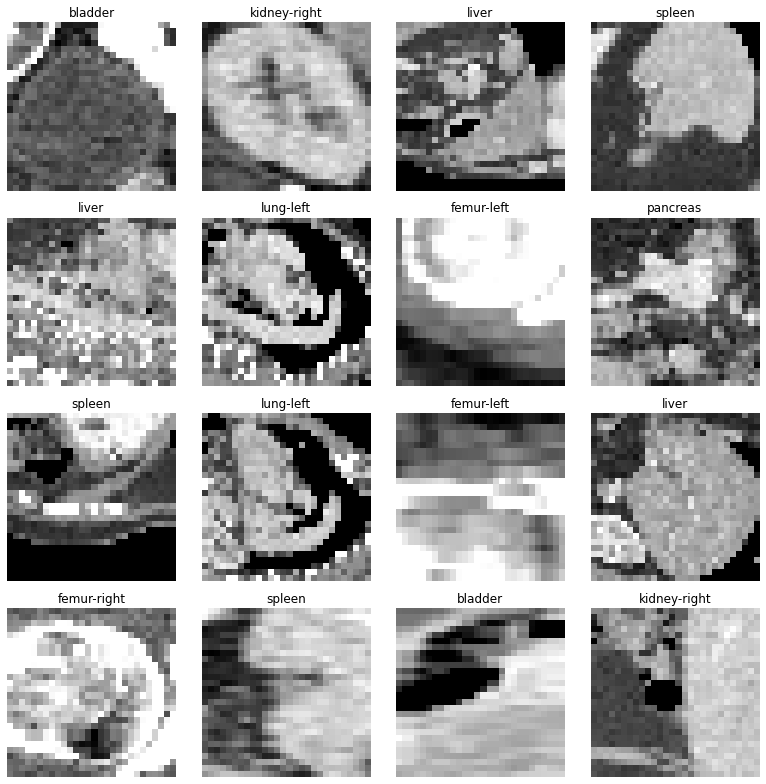

In [6]:
# Visualizamos algunas imágenes de ejemplo con sus etiquetas
offset = 0
plt.rcParams["figure.figsize"] = [11, 11]

fig = plt.figure()
for i in range(1 + offset, 17 + offset):
    ax = fig.add_subplot(4, 4, i - offset)
    img = visual_dataset[i][0]
    lbl = visual_dataset[i][1]
    ax.imshow(img, cmap="gray")
    ax.set_title(info["label"][str(lbl[0])])
    ax.axis(False)
fig.tight_layout()

In [7]:
fig.savefig("figures/ejemplo_dataset.svg")

In [8]:
def get_target_preds(net, loader):
    preds = []
    targets = []
    net.eval()
    for x, y in loader:
        with torch.no_grad():
            x = x.cuda()
            output = net(x).argmax(axis=1)
            targets.extend(list(y[:, 0].numpy()))
            preds.extend(list(output.cpu().numpy()))

    targets, preds = np.array(targets), np.array(preds)
    mapping = {int(k): v.capitalize() for (k, v) in info["label"].items()}
    mapping = np.vectorize(mapping.get)
    targets = mapping(targets)
    preds = mapping(preds)
    return targets, preds


def get_metrics(target, pred) -> tuple:
    """
    Retorna una lista con los siguientes elementos en orden:
    accuracy, precision, recall, f1-score, support
    """
    warnings.filterwarnings("ignore")
    report_dict = classification_report(target, pred, output_dict=True)
    return report_dict["accuracy"], *report_dict["weighted avg"].values()


def eval_model(net) -> pd.DataFrame:
    train_target, train_pred = get_target_preds(net, train_loader)
    val_target, val_pred = get_target_preds(net, val_loader)
    test_target, test_pred = get_target_preds(net, test_loader)
    columns = pd.MultiIndex.from_product(
        [
            ["Train", "Val", "Test"],
            ["accuracy", "precision", "recall", "f1-score", "support"],
        ]
    )

    df = pd.DataFrame(columns=columns)
    df.loc["Base", "Train"] = get_metrics(train_target, train_pred)
    df.loc["Base", "Val"] = get_metrics(val_target, val_pred)
    df.loc["Base", "Test"] = get_metrics(test_target, test_pred)

    fig, ax = plt.subplots(1, 2)
    ConfusionMatrixDisplay.from_predictions(
        train_target,
        train_pred,
        colorbar=False,
        ax=ax[0],
        xticks_rotation=60,
        cmap="binary",
    )
    ax[0].set_title("Train")
    ConfusionMatrixDisplay.from_predictions(
        val_target,
        val_pred,
        colorbar=False,
        ax=ax[1],
        xticks_rotation=60,
        cmap="binary",
    )
    ax[1].set_title("Val")
    fig.tight_layout()
    return df, fig

In [9]:
def trainer(
    net,
    train_loader,
    test_loader,
    *,
    num_epochs: int = 5,  # if early stopping is True will be ignored
    input_features=28 * 28 * 3,
    learning_rate=0.001,
    early_stopping: bool = False,
    pattience: int = 5,
    use_adamw: bool = False,
    weight_decay: float = 0.0,
):
    # Construimos el optimizador, y le indicamos que los parámetros a optimizar
    # son los del modelo definido: net.parameters()
    if use_adamw:
        optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate)
    else:
        optimizer = torch.optim.Adam(
            net.parameters(), lr=learning_rate, weight_decay=weight_decay
        )

    # Definimos también la función de pérdida a utilizar
    criterion = nn.CrossEntropyLoss()

    # Creamos un loader iterable indicandole que debe leer los datos a partir de
    # del dataset creado en el paso anterior. Este objeto puede ser iterado
    # y nos devuelve de a un batch (x, y).

    # Lista en la que iremos guardando el valor de la función de pérdida en cada
    # etapa de entrenamiento
    loss_list = []

    acc_list = []
    acc_test_list = []
    iter_test_loader = iter(test_loader)

    if early_stopping:
        # configure early_stopping
        best_acc = 0
        n_without_improvment = 0
        num_epochs = 1_000  # any big number
        best_model = deepcopy(net)

    # Bucle de entrenamiento
    for i in range(num_epochs):
        print("Epoch : " + str(i))
        loss_list_epoch = []
        # Itero sobre todos los batches del dataset
        for x, y in tqdm(train_loader):
            net.train()
            # Seteo en cero los gradientes de los parámetros a optimizar
            optimizer.zero_grad()

            # Movemos los tensores a memoria de GPU
            x = x.to(device)
            y = y.to(device)
            y = y.squeeze().long()
            pred = net(x)

            # Realizo la pasada forward por la red
            loss = criterion(pred, y)

            # Realizo la pasada backward por la red
            loss.backward()

            # Actualizo los pesos de la red con el optimizador
            optimizer.step()

            # Acc
            with torch.no_grad():
                net.eval()
                acc = (pred.argmax(dim=1) == y).sum() / y.size(0)
                try:
                    x_val, y_val = next(iter_test_loader)
                except StopIteration:
                    iter_test_loader = iter(test_loader)
                    x_val, y_val = next(iter_test_loader)

                x_val = x_val.to(device)
                y_val = y_val.to(device)
                y_val = y_val.squeeze().long()
                pred_val = net(x_val)
                acc_val = (pred_val.argmax(dim=1) == y_val).sum() / y_val.size(0)

            # Me guardo el valor actual de la función de pérdida para luego graficarlo
            loss_list.append(loss.data.item())
            loss_list_epoch.append(loss.data.item())
            acc_list.append(acc.data.item())
            acc_test_list.append(acc_val.data.item())

        if early_stopping:
            val_target, val_pred = get_target_preds(net, val_loader)
            accuracy = (val_target == val_pred).mean()
            if accuracy > best_acc:
                print(f"Accuracy is improved from {best_acc:.3f} to {accuracy:.3f}")
                best_acc = accuracy
                n_without_improvment = 0
                best_model = deepcopy(net)
            else:
                n_without_improvment += 1
                print(f"Accuracy isn't improved for {n_without_improvment} epoch")
                if n_without_improvment >= pattience:
                    net.load_state_dict(best_model.state_dict())
                    print(f"Train has finished after {i} epochs")
                    break

        print(
            "Epoch %d, Avg train loss during epoch = %g"
            % (i, np.array(loss_list_epoch).mean())
        )
    return loss_list, acc_list, acc_test_list


def plot_loss(loss_list, ax):
    # Muestro la lista que contiene los valores de la función de pérdida
    # y una versión suavizada (rojo) para observar la tendencia
    loss_np_array = np.array(loss_list)
    ax.plot(loss_np_array, alpha=0.3, label="loss")
    N = 60
    running_avg_loss = np.convolve(loss_np_array, np.ones((N,)) / N, mode="valid")
    ax.plot(running_avg_loss, color="red", label="loss suavizada")
    ax.set_title("Función de pérdida durante el entrenamiento")
    ax.legend()
    ax.grid(True)
    ax.set_xlabel("Step")
    ax.set_ylabel("Loss")


def plot_acc(acc_list, acc_test_list, ax):
    acc_np_array = np.array(acc_list)
    ax.plot(acc_np_array, alpha=0.3, color="red", label="acc_train")
    N = 60
    running_avg_loss = np.convolve(acc_np_array, np.ones((N,)) / N, mode="valid")
    ax.plot(running_avg_loss, color="red", label="acc_train suavizada")

    acc_test_np_array = np.array(acc_test_list)
    ax.plot(acc_test_np_array, alpha=0.3, color="blue", label="acc_val")
    N = 60
    running_test_avg_loss = np.convolve(
        acc_test_np_array, np.ones((N,)) / N, mode="valid"
    )
    ax.plot(running_test_avg_loss, color="blue", label="acc_val suavizada")
    ax.set_title("Accuracy durante el entrenamiento")
    ax.legend()
    ax.grid(True)
    ax.set_xlabel("Step")
    ax.set_ylabel("Accuracy")

# Red Neuronal Convolucional

También definiremos un modelo NetCNN que implemente una red neuronal convolucional, el cual seguirá la siguiente estructura:
* Capa convolucional (6 feature maps de salida) + ReLU
* Max pooling 2 x 2
* Capa convolucional (16 feature maps de salida) + ReLU
* Max pooling 2 x 2
* Capa totalmente conectada (120 neuronas) + ReLU
* Capa totalmente conectada (84 neuronas) + ReLU
* Capa de salida (10 neuronas)

Notar que utilizaremos la función `CrossEntropyLoss` para entrenar el modelo. Recordar que dados:
* F: tamaño del filtro
* W: Tamaño del feature map de entrada
* P: Padding
* S: Stride

El tamaño de la salida es $O = \frac{(W - F + 2P)}{S} + 1$


In [10]:
class NetCNN(nn.Module):
    def __init__(self, *, n_classes):
        super(NetCNN, self).__init__()
        # 3 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_classes)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.conv1(x)  # batch_size x 6 x 28 x 28
        x = F.relu(x)  # batch_size x 6 x 28 x 28
        x = F.max_pool2d(x, kernel_size=2)  # batch_size x 6 x 14 x 14
        x = self.conv2(x)  # batch_size x 16 x 14 x14
        x = F.relu(x)  # batch_size x 16 x 14 x 14
        x = F.max_pool2d(x, kernel_size=2)  # batch_size x 16 x 7 x 7
        x = x.view(x.size(0), -1)  # batch_size x 16*7*7
        x = self.fc1(x)  # batch_size x 120
        x = F.relu(x)
        x = self.fc2(x)  # batch_size x 84
        x = F.relu(x)
        x = self.fc3(x)  # batch_size x 9
        return x

In [11]:
pl.seed_everything(1)

# Numero de epocas de entrenamiento
num_epochs = 5

# Dispositivo en que se ejecturá el modelo: 'cuda:0' para GPU y 'cpu' para CPU
device = torch.device("cuda:0")

net = NetCNN(n_classes=n_classes)
net.to(device)

loss_list, acc_list, acc_val_list = trainer(
    net,
    train_loader,
    val_loader,
    num_epochs=num_epochs,
)

Global seed set to 1


Epoch : 0


100%|█████████████████████████████████████████| 109/109 [00:04<00:00, 21.84it/s]


Epoch 0, Avg train loss during epoch = 1.76174
Epoch : 1


100%|█████████████████████████████████████████| 109/109 [00:04<00:00, 22.06it/s]


Epoch 1, Avg train loss during epoch = 1.06229
Epoch : 2


100%|█████████████████████████████████████████| 109/109 [00:04<00:00, 21.96it/s]


Epoch 2, Avg train loss during epoch = 0.818069
Epoch : 3


100%|█████████████████████████████████████████| 109/109 [00:04<00:00, 22.12it/s]


Epoch 3, Avg train loss during epoch = 0.715883
Epoch : 4


100%|█████████████████████████████████████████| 109/109 [00:04<00:00, 21.83it/s]

Epoch 4, Avg train loss during epoch = 0.650842


level_1,accuracy,f1-score,precision,recall
level_0,,,,
Train,0.775,0.775,0.780,0.775
Val,0.815,0.812,0.825,0.815


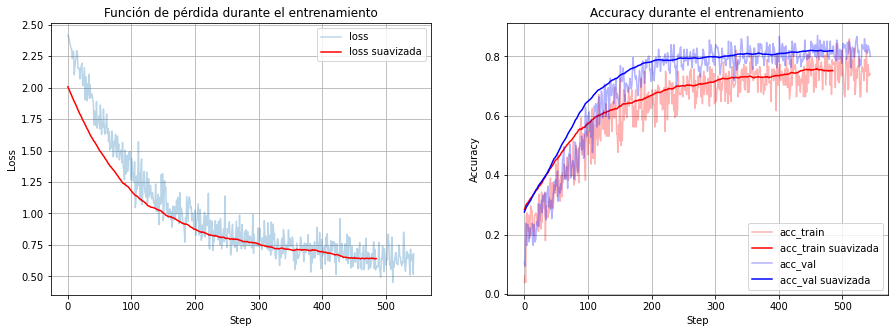

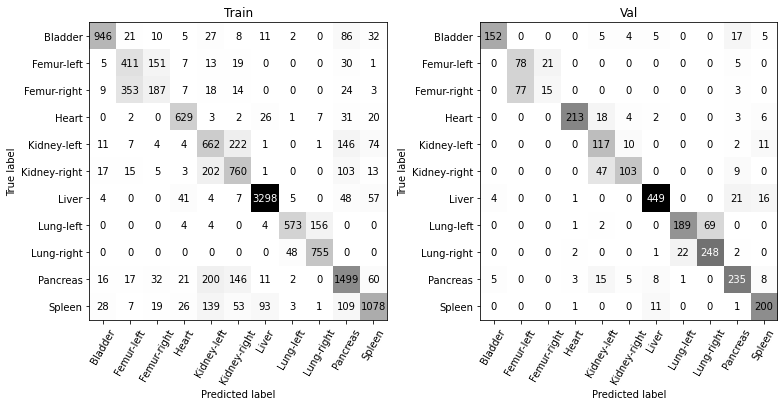

In [12]:
# Figuras de loss de train y evolucion de la acc
fig_train_base, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_loss(loss_list, ax[0])
plot_acc(acc_list, acc_val_list, ax[1])
fig_train_base.savefig("figures/train_base.svg")

# metricas de desempeño y matriz de confusion
df_base, fig_conf_matr_base = eval_model(net)
fig_conf_matr_base.savefig("figures/conf_matr_base.svg")

df_base_aux = pd.pivot_table(
    df_base.T.reset_index(), values="Base", index="level_0", columns="level_1"
)
df_base_aux.applymap(lambda x: round(x, 3)).loc[["Train", "Val"]].iloc[:, :4]

# Mejora 1: Early Stopping

In [13]:
pl.seed_everything(1)
# Dispositivo en que se ejecturá el modelo: 'cuda:0' para GPU y 'cpu' para CPU
device = torch.device("cuda:0")

net = NetCNN(n_classes=n_classes)
net.to(device)

loss_list, acc_list, acc_val_list = trainer(
    net, train_loader, val_loader, early_stopping=True
)

Global seed set to 1


Epoch : 0


100%|█████████████████████████████████████████| 109/109 [00:05<00:00, 21.68it/s]


Accuracy is improved from 0.000 to 0.562
Epoch 0, Avg train loss during epoch = 1.76174
Epoch : 1


100%|█████████████████████████████████████████| 109/109 [00:04<00:00, 22.02it/s]


Accuracy is improved from 0.562 to 0.768
Epoch 1, Avg train loss during epoch = 1.04506
Epoch : 2


100%|█████████████████████████████████████████| 109/109 [00:05<00:00, 21.75it/s]


Accuracy is improved from 0.768 to 0.782
Epoch 2, Avg train loss during epoch = 0.812957
Epoch : 3


100%|█████████████████████████████████████████| 109/109 [00:04<00:00, 21.89it/s]


Accuracy is improved from 0.782 to 0.814
Epoch 3, Avg train loss during epoch = 0.710557
Epoch : 4


100%|█████████████████████████████████████████| 109/109 [00:05<00:00, 21.67it/s]


Accuracy is improved from 0.814 to 0.823
Epoch 4, Avg train loss during epoch = 0.649756
Epoch : 5


100%|█████████████████████████████████████████| 109/109 [00:04<00:00, 21.89it/s]


Accuracy isn't improved for 1 epoch
Epoch 5, Avg train loss during epoch = 0.587933
Epoch : 6


100%|█████████████████████████████████████████| 109/109 [00:05<00:00, 21.70it/s]


Accuracy isn't improved for 2 epoch
Epoch 6, Avg train loss during epoch = 0.552596
Epoch : 7


100%|█████████████████████████████████████████| 109/109 [00:04<00:00, 21.84it/s]


Accuracy is improved from 0.823 to 0.833
Epoch 7, Avg train loss during epoch = 0.519445
Epoch : 8


100%|█████████████████████████████████████████| 109/109 [00:05<00:00, 21.65it/s]


Accuracy isn't improved for 1 epoch
Epoch 8, Avg train loss during epoch = 0.47957
Epoch : 9


100%|█████████████████████████████████████████| 109/109 [00:05<00:00, 21.76it/s]


Accuracy isn't improved for 2 epoch
Epoch 9, Avg train loss during epoch = 0.458706
Epoch : 10


100%|█████████████████████████████████████████| 109/109 [00:05<00:00, 21.61it/s]


Accuracy isn't improved for 3 epoch
Epoch 10, Avg train loss during epoch = 0.43124
Epoch : 11


100%|█████████████████████████████████████████| 109/109 [00:05<00:00, 21.62it/s]


Accuracy isn't improved for 4 epoch
Epoch 11, Avg train loss during epoch = 0.388778
Epoch : 12


100%|█████████████████████████████████████████| 109/109 [00:05<00:00, 21.70it/s]


Accuracy isn't improved for 5 epoch
Train has finished after 12 epochs


level_1,accuracy,f1-score,precision,recall
level_0,,,,
Train,0.809,0.798,0.808,0.809
Val,0.833,0.828,0.836,0.833


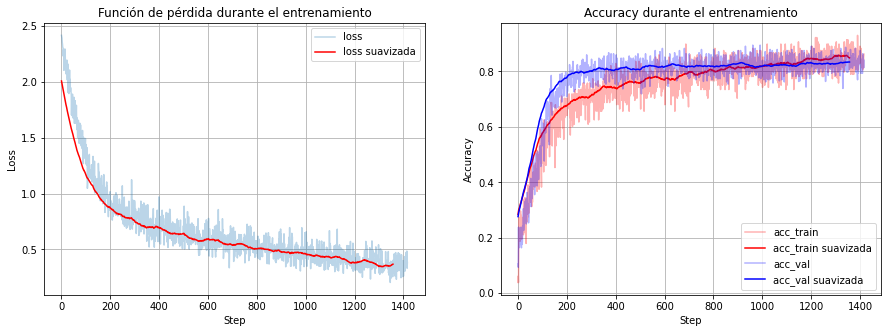

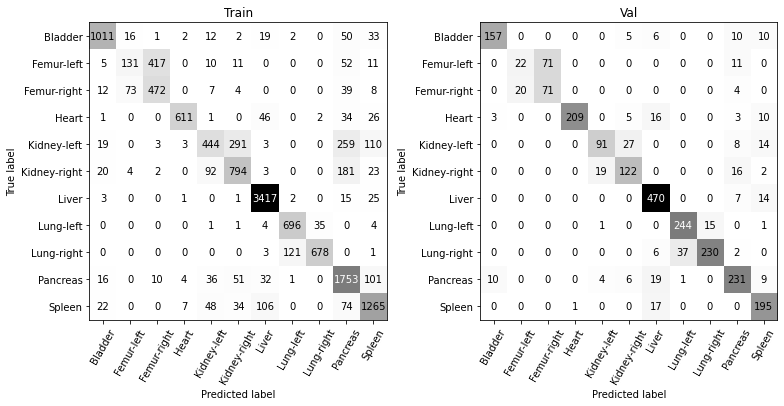

In [14]:
# Figuras de loss de train y evolucion de la acc
fig_train_early_stopping, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_loss(loss_list, ax[0])
plot_acc(acc_list, acc_val_list, ax[1])
fig_train_early_stopping.savefig("figures/train_early_stopping.svg")

# metricas de desempeño y matriz de confusion
df_early_stopping, fig_conf_matr_early_stopping = eval_model(net)
fig_conf_matr_early_stopping.savefig("figures/conf_matr_early_stopping.svg")

df_early_stopping_aux = pd.pivot_table(
    df_early_stopping.T.reset_index(), values="Base", index="level_0", columns="level_1"
)
df_early_stopping_aux.applymap(lambda x: round(x, 3)).loc[["Train", "Val"]].iloc[:, :4]

# Mejora 2: Bigger model

In [15]:
class NetCNN(nn.Module):
    def __init__(self, *, n_classes):
        super(NetCNN, self).__init__()
        # 3 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 24, 5, padding=2)
        self.conv_bn1 = nn.BatchNorm2d(24)
        self.conv2 = nn.Conv2d(24, 64, 5, padding=2)
        self.conv_bn2 = nn.BatchNorm2d(64)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(64 * 7 * 7, 480)
        self.fc_bn1 = nn.BatchNorm1d(480)
        self.fc2 = nn.Linear(480, 240)
        self.fc_bn2 = nn.BatchNorm1d(240)
        self.fc3 = nn.Linear(240, n_classes)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.conv1(x)  # batch_size x 6 x 28 x 28
        # x = self.conv_bn1(x)
        x = F.relu(x)  # batch_size x 6 x 28 x 28
        x = F.max_pool2d(x, kernel_size=2)  # batch_size x 6 x 14 x 14
        x = self.conv2(x)  # batch_size x 16 x 14 x14
        # x = self.conv_bn2(x)
        x = F.relu(x)  # batch_size x 16 x 14 x 14
        x = F.max_pool2d(x, kernel_size=2)  # batch_size x 16 x 7 x 7
        x = x.view(x.size(0), -1)  # batch_size x 16*7*7
        x = self.fc1(x)  # batch_size x 120
        # x = self.fc_bn1(x)
        x = F.relu(x)
        x = self.fc2(x)  # batch_size x 84
        # x = self.fc_bn2(x)
        x = F.relu(x)
        x = self.fc3(x)  # batch_size x 9
        return x

In [16]:
pl.seed_everything(1)
# Dispositivo en que se ejecturá el modelo: 'cuda:0' para GPU y 'cpu' para CPU
device = torch.device("cuda:0")

net = NetCNN(n_classes=n_classes)
net.to(device)

loss_list, acc_list, acc_val_list = trainer(
    net, train_loader, val_loader, early_stopping=True
)

Global seed set to 1


Epoch : 0


100%|█████████████████████████████████████████| 109/109 [00:05<00:00, 21.19it/s]


Accuracy is improved from 0.000 to 0.811
Epoch 0, Avg train loss during epoch = 1.26354
Epoch : 1


100%|█████████████████████████████████████████| 109/109 [00:05<00:00, 21.12it/s]


Accuracy is improved from 0.811 to 0.831
Epoch 1, Avg train loss during epoch = 0.641507
Epoch : 2


100%|█████████████████████████████████████████| 109/109 [00:05<00:00, 21.36it/s]


Accuracy is improved from 0.831 to 0.856
Epoch 2, Avg train loss during epoch = 0.459728
Epoch : 3


100%|█████████████████████████████████████████| 109/109 [00:05<00:00, 21.26it/s]


Accuracy is improved from 0.856 to 0.862
Epoch 3, Avg train loss during epoch = 0.350534
Epoch : 4


100%|█████████████████████████████████████████| 109/109 [00:05<00:00, 21.40it/s]


Accuracy isn't improved for 1 epoch
Epoch 4, Avg train loss during epoch = 0.274397
Epoch : 5


100%|█████████████████████████████████████████| 109/109 [00:05<00:00, 21.30it/s]


Accuracy isn't improved for 2 epoch
Epoch 5, Avg train loss during epoch = 0.201945
Epoch : 6


100%|█████████████████████████████████████████| 109/109 [00:05<00:00, 21.42it/s]


Accuracy isn't improved for 3 epoch
Epoch 6, Avg train loss during epoch = 0.136035
Epoch : 7


100%|█████████████████████████████████████████| 109/109 [00:05<00:00, 21.46it/s]


Accuracy isn't improved for 4 epoch
Epoch 7, Avg train loss during epoch = 0.107338
Epoch : 8


100%|█████████████████████████████████████████| 109/109 [00:05<00:00, 21.24it/s]


Accuracy isn't improved for 5 epoch
Train has finished after 8 epochs


level_1,accuracy,f1-score,precision,recall
level_0,,,,
Train,0.893,0.884,0.902,0.893
Val,0.862,0.849,0.849,0.862


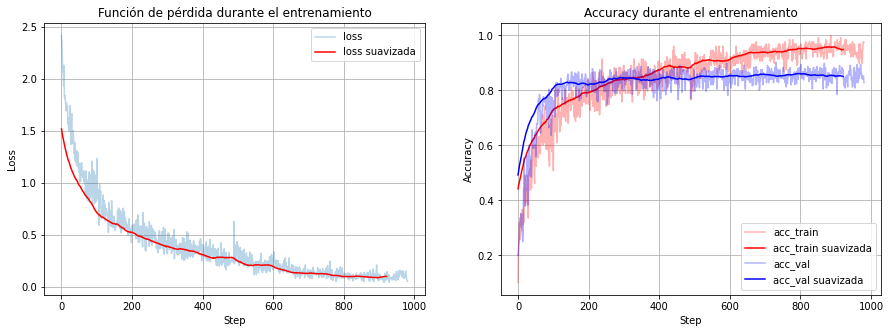

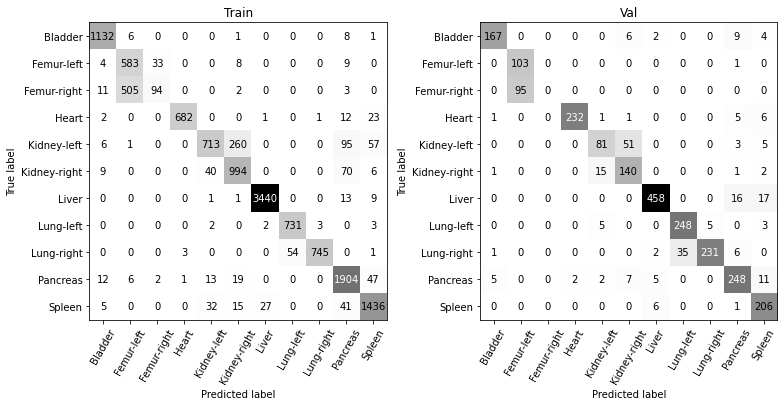

In [17]:
# Figuras de loss de train y evolucion de la acc
fig_train_big, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_loss(loss_list, ax[0])
plot_acc(acc_list, acc_val_list, ax[1])
fig_train_big.savefig("figures/train_data_big.svg")

# metricas de desempeño y matriz de confusion
df_big, fig_conf_matr_big = eval_model(net)
fig_conf_matr_big.savefig("figures/conf_matr_big.svg")

df_big_aux = pd.pivot_table(
    df_big.T.reset_index(),
    values="Base",
    index="level_0",
    columns="level_1",
)
df_big_aux.applymap(lambda x: round(x, 3)).loc[["Train", "Val"]].iloc[:, :4]

# Mejora 3: Data Augmentation

In [18]:
# Transformaciones que serán utilizadas para normalizar las imagenes
data_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]
)
data_transform_aug = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
        transforms.RandomRotation(degrees=30),
        transforms.RandomErasing(),
        transforms.RandomPerspective(p=0.1),
    ]
)

# Creo los datasets
train_dataset_augmented = DataClass(
    split="train", transform=data_transform_aug, download=False
)
train_dataset = DataClass(split="train", transform=data_transform, download=False)
val_dataset = DataClass(split="val", transform=data_transform, download=False)
test_dataset = DataClass(split="test", transform=data_transform, download=False)

# Encapsulo los datasets en un dataloader
train_loader_augmented = data.DataLoader(
    dataset=train_dataset_augmented, batch_size=BATCH_SIZE, shuffle=True
)
train_loader = data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
val_loader = data.DataLoader(
    dataset=val_dataset, batch_size=2 * BATCH_SIZE, shuffle=False
)
test_loader = data.DataLoader(
    dataset=test_dataset, batch_size=2 * BATCH_SIZE, shuffle=False
)

In [19]:
pl.seed_everything(1)
# Dispositivo en que se ejecturá el modelo: 'cuda:0' para GPU y 'cpu' para CPU
device = torch.device("cuda:0")

net = NetCNN(n_classes=n_classes)
net.to(device)

loss_list, acc_list, acc_val_list = trainer(
    net, train_loader_augmented, val_loader, early_stopping=True
)

Global seed set to 1


Epoch : 0


100%|█████████████████████████████████████████| 109/109 [00:10<00:00, 10.29it/s]


Accuracy is improved from 0.000 to 0.722
Epoch 0, Avg train loss during epoch = 1.51422
Epoch : 1


100%|█████████████████████████████████████████| 109/109 [00:10<00:00, 10.33it/s]


Accuracy is improved from 0.722 to 0.816
Epoch 1, Avg train loss during epoch = 0.993534
Epoch : 2


100%|█████████████████████████████████████████| 109/109 [00:10<00:00, 10.32it/s]


Accuracy is improved from 0.816 to 0.841
Epoch 2, Avg train loss during epoch = 0.80319
Epoch : 3


100%|█████████████████████████████████████████| 109/109 [00:10<00:00, 10.23it/s]


Accuracy is improved from 0.841 to 0.844
Epoch 3, Avg train loss during epoch = 0.682954
Epoch : 4


100%|█████████████████████████████████████████| 109/109 [00:10<00:00, 10.20it/s]


Accuracy is improved from 0.844 to 0.868
Epoch 4, Avg train loss during epoch = 0.6258
Epoch : 5


100%|█████████████████████████████████████████| 109/109 [00:10<00:00, 10.11it/s]


Accuracy isn't improved for 1 epoch
Epoch 5, Avg train loss during epoch = 0.565792
Epoch : 6


100%|█████████████████████████████████████████| 109/109 [00:10<00:00, 10.19it/s]


Accuracy isn't improved for 2 epoch
Epoch 6, Avg train loss during epoch = 0.519896
Epoch : 7


100%|█████████████████████████████████████████| 109/109 [00:10<00:00, 10.16it/s]


Accuracy is improved from 0.868 to 0.891
Epoch 7, Avg train loss during epoch = 0.485376
Epoch : 8


100%|█████████████████████████████████████████| 109/109 [00:10<00:00, 10.25it/s]


Accuracy isn't improved for 1 epoch
Epoch 8, Avg train loss during epoch = 0.453416
Epoch : 9


100%|█████████████████████████████████████████| 109/109 [00:10<00:00, 10.29it/s]


Accuracy isn't improved for 2 epoch
Epoch 9, Avg train loss during epoch = 0.410758
Epoch : 10


100%|█████████████████████████████████████████| 109/109 [00:10<00:00, 10.23it/s]


Accuracy isn't improved for 3 epoch
Epoch 10, Avg train loss during epoch = 0.406308
Epoch : 11


100%|█████████████████████████████████████████| 109/109 [00:10<00:00,  9.99it/s]


Accuracy isn't improved for 4 epoch
Epoch 11, Avg train loss during epoch = 0.373979
Epoch : 12


100%|█████████████████████████████████████████| 109/109 [00:10<00:00, 10.29it/s]


Accuracy isn't improved for 5 epoch
Train has finished after 12 epochs


level_1,accuracy,f1-score,precision,recall
level_0,,,,
Train,0.880,0.878,0.883,0.880
Val,0.891,0.891,0.893,0.891


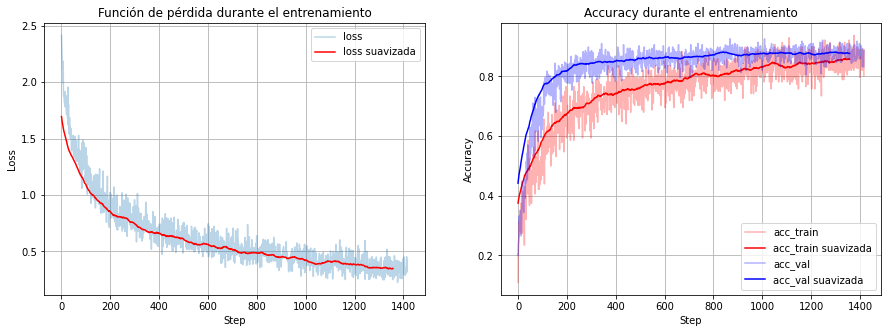

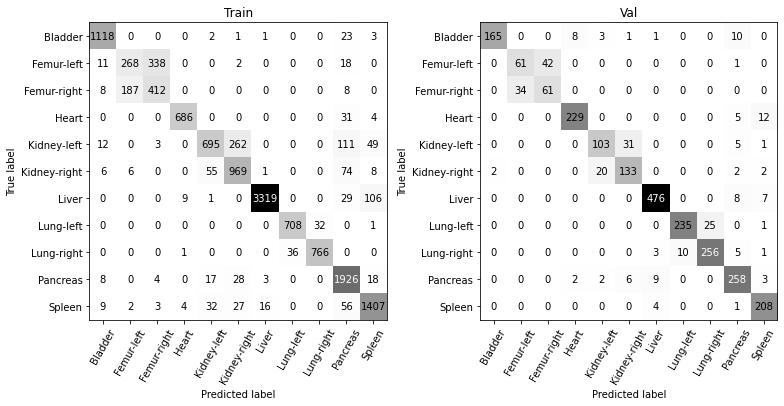

In [20]:
# Figuras de loss de train y evolucion de la acc
fig_train_data_augmentation, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_loss(loss_list, ax[0])
plot_acc(acc_list, acc_val_list, ax[1])
fig_train_data_augmentation.savefig("figures/train_data_augmentation.svg")

# metricas de desempeño y matriz de confusion
df_data_augmentation, fig_conf_matr_data_augmentation = eval_model(net)
fig_conf_matr_data_augmentation.savefig("figures/conf_matr_data_augmentation.svg")

df_data_augmentation_aux = pd.pivot_table(
    df_data_augmentation.T.reset_index(),
    values="Base",
    index="level_0",
    columns="level_1",
)
df_data_augmentation_aux.applymap(lambda x: round(x, 3)).loc[["Train", "Val"]].iloc[
    :, :4
]

# Mejora 4: Batch Normalization

In [21]:
class NetCNN(nn.Module):
    def __init__(self, *, n_classes):
        super(NetCNN, self).__init__()
        # 3 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 24, 5, padding=2)
        self.conv_bn1 = nn.BatchNorm2d(24)
        self.conv2 = nn.Conv2d(24, 64, 5, padding=2)
        self.conv_bn2 = nn.BatchNorm2d(64)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(64 * 7 * 7, 480)
        self.fc_bn1 = nn.BatchNorm1d(480)
        self.fc2 = nn.Linear(480, 240)
        self.fc_bn2 = nn.BatchNorm1d(240)
        self.fc3 = nn.Linear(240, n_classes)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.conv1(x)  # batch_size x 6 x 28 x 28
        x = self.conv_bn1(x)
        x = F.relu(x)  # batch_size x 6 x 28 x 28
        x = F.max_pool2d(x, kernel_size=2)  # batch_size x 6 x 14 x 14
        x = self.conv2(x)  # batch_size x 16 x 14 x14
        x = self.conv_bn2(x)
        x = F.relu(x)  # batch_size x 16 x 14 x 14
        x = F.max_pool2d(x, kernel_size=2)  # batch_size x 16 x 7 x 7
        x = x.view(x.size(0), -1)  # batch_size x 16*7*7
        x = self.fc1(x)  # batch_size x 120
        x = self.fc_bn1(x)
        x = F.relu(x)
        x = self.fc2(x)  # batch_size x 84
        x = self.fc_bn2(x)
        x = F.relu(x)
        x = self.fc3(x)  # batch_size x 9
        return x

In [22]:
pl.seed_everything(1)
# Dispositivo en que se ejecturá el modelo: 'cuda:0' para GPU y 'cpu' para CPU
device = torch.device("cuda:0")

net = NetCNN(n_classes=n_classes)
net.to(device)

loss_list, acc_list, acc_val_list = trainer(
    net, train_loader_augmented, val_loader, early_stopping=True
)

Global seed set to 1


Epoch : 0


100%|█████████████████████████████████████████| 109/109 [00:10<00:00, 10.16it/s]


Accuracy is improved from 0.000 to 0.821
Epoch 0, Avg train loss during epoch = 1.01418
Epoch : 1


100%|█████████████████████████████████████████| 109/109 [00:10<00:00, 10.33it/s]


Accuracy isn't improved for 1 epoch
Epoch 1, Avg train loss during epoch = 0.679667
Epoch : 2


100%|█████████████████████████████████████████| 109/109 [00:10<00:00, 10.32it/s]


Accuracy isn't improved for 2 epoch
Epoch 2, Avg train loss during epoch = 0.57864
Epoch : 3


100%|█████████████████████████████████████████| 109/109 [00:10<00:00, 10.31it/s]


Accuracy is improved from 0.821 to 0.855
Epoch 3, Avg train loss during epoch = 0.518218
Epoch : 4


100%|█████████████████████████████████████████| 109/109 [00:10<00:00, 10.31it/s]


Accuracy is improved from 0.855 to 0.863
Epoch 4, Avg train loss during epoch = 0.472782
Epoch : 5


100%|█████████████████████████████████████████| 109/109 [00:10<00:00, 10.34it/s]


Accuracy is improved from 0.863 to 0.889
Epoch 5, Avg train loss during epoch = 0.436824
Epoch : 6


100%|█████████████████████████████████████████| 109/109 [00:10<00:00, 10.27it/s]


Accuracy isn't improved for 1 epoch
Epoch 6, Avg train loss during epoch = 0.404258
Epoch : 7


100%|█████████████████████████████████████████| 109/109 [00:10<00:00, 10.28it/s]


Accuracy isn't improved for 2 epoch
Epoch 7, Avg train loss during epoch = 0.376731
Epoch : 8


100%|█████████████████████████████████████████| 109/109 [00:10<00:00, 10.29it/s]


Accuracy isn't improved for 3 epoch
Epoch 8, Avg train loss during epoch = 0.353035
Epoch : 9


100%|█████████████████████████████████████████| 109/109 [00:10<00:00, 10.33it/s]


Accuracy is improved from 0.889 to 0.903
Epoch 9, Avg train loss during epoch = 0.31972
Epoch : 10


100%|█████████████████████████████████████████| 109/109 [00:10<00:00, 10.34it/s]


Accuracy isn't improved for 1 epoch
Epoch 10, Avg train loss during epoch = 0.320739
Epoch : 11


100%|█████████████████████████████████████████| 109/109 [00:10<00:00, 10.33it/s]


Accuracy isn't improved for 2 epoch
Epoch 11, Avg train loss during epoch = 0.304302
Epoch : 12


100%|█████████████████████████████████████████| 109/109 [00:10<00:00, 10.32it/s]


Accuracy isn't improved for 3 epoch
Epoch 12, Avg train loss during epoch = 0.286293
Epoch : 13


100%|█████████████████████████████████████████| 109/109 [00:10<00:00, 10.32it/s]


Accuracy isn't improved for 4 epoch
Epoch 13, Avg train loss during epoch = 0.289175
Epoch : 14


100%|█████████████████████████████████████████| 109/109 [00:10<00:00, 10.22it/s]


Accuracy isn't improved for 5 epoch
Train has finished after 14 epochs


level_1,accuracy,f1-score,precision,recall
level_0,,,,
Train,0.934,0.934,0.934,0.934
Val,0.903,0.901,0.905,0.903


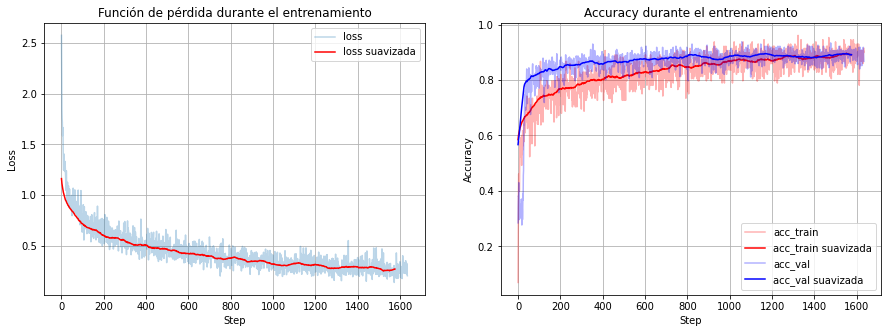

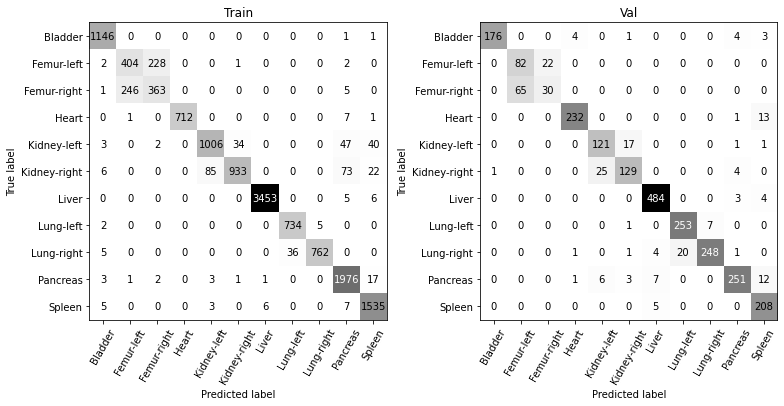

In [23]:
# Figuras de loss de train y evolucion de la acc
fig_train_batch_norm, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_loss(loss_list, ax[0])
plot_acc(acc_list, acc_val_list, ax[1])
fig_train_batch_norm.savefig("figures/train_data_batch_norm.svg")

# metricas de desempeño y matriz de confusion
df_batch_norm, fig_conf_matr_batch_norm = eval_model(net)
fig_conf_matr_batch_norm.savefig("figures/conf_matr_batch_norm.svg")

df_batch_norm_aux = pd.pivot_table(
    df_batch_norm.T.reset_index(),
    values="Base",
    index="level_0",
    columns="level_1",
)
df_batch_norm_aux.applymap(lambda x: round(x, 3)).loc[["Train", "Val"]].iloc[:, :4]

# Resumen de resultados

In [24]:
df_results = pd.concat(
    [
        df_base,
        df_early_stopping,
        df_big,
        df_data_augmentation,
        df_batch_norm,
    ]
)
df_results.index = [
    "Base",
    "Early Stopping",
    "Big",
    "Data Augmentation",
    "Batch Normalization",
]
df_results.iloc[:, df_results.columns.get_level_values(1) != "support"].applymap(
    lambda x: round(x, 3)
)

Train                                Val            \
                    accuracy precision recall f1-score accuracy precision   
Base                   0.775     0.780  0.775    0.775    0.815     0.825   
Early Stopping         0.809     0.808  0.809    0.798    0.833     0.836   
Big                    0.893     0.902  0.893    0.884    0.862     0.849   
Data Augmentation      0.880     0.883  0.880    0.878    0.891     0.893   
Batch Normalization    0.934     0.934  0.934    0.934    0.903     0.905   

                                        Test                            
                    recall f1-score accuracy precision recall f1-score  
Base                 0.815    0.812    0.677     0.682  0.677    0.675  
Early Stopping       0.833    0.828    0.683     0.675  0.683    0.669  
Big                  0.862    0.849    0.723     0.725  0.723    0.714  
Data Augmentation    0.891    0.891    0.741     0.742  0.741    0.738  
Batch Normalization  0.903    0.901    0.762     0.763  0.762    0.758

# Mejora 5: Ensembles 

In [25]:
class ResNet(nn.Module):
    def __init__(self, size: int):
        super().__init__()
        if size == 18:
            self.model = models.resnet18(pretrained=True)
        if size == 34:
            self.model = models.resnet34(pretrained=True)
        elif size == 50:
            self.model = models.resnet50(pretrained=True)
        if size == 101:
            self.model = models.resnet101(pretrained=True)
        elif size == 152:
            self.model = models.resnet152(pretrained=True)
        self.model.fc = nn.Linear(2048, n_classes)

    def forward(self, x):
        x = x.repeat(1, 3, 1, 1)
        x = self.model(x)
        return x

In [26]:
pl.seed_everything(1)
# Dispositivo en que se ejecturá el modelo: 'cuda:0' para GPU y 'cpu' para CPU
device = torch.device("cuda:0")

# net = NetCNN(n_classes=n_classes)
resnet50 = ResNet(50)
resnet50.to(device)

loss_list, acc_list, acc_val_list = trainer(
    resnet50, train_loader_augmented, val_loader, early_stopping=True
)

Global seed set to 1


Epoch : 0


100%|█████████████████████████████████████████| 109/109 [00:21<00:00,  5.18it/s]


Accuracy is improved from 0.000 to 0.792
Epoch 0, Avg train loss during epoch = 0.950621
Epoch : 1


100%|█████████████████████████████████████████| 109/109 [00:21<00:00,  5.18it/s]


Accuracy is improved from 0.792 to 0.883
Epoch 1, Avg train loss during epoch = 0.572476
Epoch : 2


100%|█████████████████████████████████████████| 109/109 [00:20<00:00,  5.21it/s]


Accuracy is improved from 0.883 to 0.894
Epoch 2, Avg train loss during epoch = 0.485864
Epoch : 3


100%|█████████████████████████████████████████| 109/109 [00:20<00:00,  5.24it/s]


Accuracy isn't improved for 1 epoch
Epoch 3, Avg train loss during epoch = 0.504352
Epoch : 4


100%|█████████████████████████████████████████| 109/109 [00:20<00:00,  5.19it/s]


Accuracy isn't improved for 2 epoch
Epoch 4, Avg train loss during epoch = 0.437607
Epoch : 5


100%|█████████████████████████████████████████| 109/109 [00:20<00:00,  5.24it/s]


Accuracy isn't improved for 3 epoch
Epoch 5, Avg train loss during epoch = 0.382733
Epoch : 6


100%|█████████████████████████████████████████| 109/109 [00:21<00:00,  5.16it/s]


Accuracy is improved from 0.894 to 0.895
Epoch 6, Avg train loss during epoch = 0.353991
Epoch : 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:21<00:00,  5.14it/s]


Accuracy isn't improved for 1 epoch
Epoch 7, Avg train loss during epoch = 0.329555
Epoch : 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:20<00:00,  5.23it/s]


Accuracy is improved from 0.895 to 0.896
Epoch 8, Avg train loss during epoch = 0.329531
Epoch : 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:21<00:00,  5.08it/s]


Accuracy isn't improved for 1 epoch
Epoch 9, Avg train loss during epoch = 0.297638
Epoch : 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:21<00:00,  5.13it/s]


Accuracy is improved from 0.896 to 0.898
Epoch 10, Avg train loss during epoch = 0.258584
Epoch : 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:22<00:00,  4.88it/s]


Accuracy isn't improved for 1 epoch
Epoch 11, Avg train loss during epoch = 0.259537
Epoch : 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:21<00:00,  4.98it/s]


Accuracy isn't improved for 2 epoch
Epoch 12, Avg train loss during epoch = 0.255882
Epoch : 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:20<00:00,  5.20it/s]


Accuracy isn't improved for 3 epoch
Epoch 13, Avg train loss during epoch = 0.440986
Epoch : 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:20<00:00,  5.22it/s]


Accuracy is improved from 0.898 to 0.901
Epoch 14, Avg train loss during epoch = 0.33293
Epoch : 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:21<00:00,  5.19it/s]


Accuracy is improved from 0.901 to 0.907
Epoch 15, Avg train loss during epoch = 0.273141
Epoch : 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:21<00:00,  5.17it/s]


Accuracy isn't improved for 1 epoch
Epoch 16, Avg train loss during epoch = 0.237358
Epoch : 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:20<00:00,  5.20it/s]


Accuracy is improved from 0.907 to 0.912
Epoch 17, Avg train loss during epoch = 0.23503
Epoch : 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:20<00:00,  5.21it/s]


Accuracy isn't improved for 1 epoch
Epoch 18, Avg train loss during epoch = 0.215151
Epoch : 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:20<00:00,  5.20it/s]


Accuracy isn't improved for 2 epoch
Epoch 19, Avg train loss during epoch = 0.205205
Epoch : 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:20<00:00,  5.22it/s]


Accuracy isn't improved for 3 epoch
Epoch 20, Avg train loss during epoch = 0.203221
Epoch : 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:20<00:00,  5.25it/s]


Accuracy isn't improved for 4 epoch
Epoch 21, Avg train loss during epoch = 0.205034
Epoch : 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:20<00:00,  5.25it/s]


Accuracy isn't improved for 5 epoch
Train has finished after 22 epochs


In [27]:
pl.seed_everything(1)
# Dispositivo en que se ejecturá el modelo: 'cuda:0' para GPU y 'cpu' para CPU
device = torch.device("cuda:0")

# net = NetCNN(n_classes=n_classes)
resnet101 = ResNet(101)
resnet101.to(device)

loss_list, acc_list, acc_val_list = trainer(
    resnet101, train_loader_augmented, val_loader, early_stopping=True
)

Global seed set to 1


Epoch : 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:28<00:00,  3.84it/s]


Accuracy is improved from 0.000 to 0.796
Epoch 0, Avg train loss during epoch = 0.949382
Epoch : 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:28<00:00,  3.85it/s]


Accuracy is improved from 0.796 to 0.897
Epoch 1, Avg train loss during epoch = 0.595993
Epoch : 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:28<00:00,  3.84it/s]


Accuracy isn't improved for 1 epoch
Epoch 2, Avg train loss during epoch = 0.515476
Epoch : 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:28<00:00,  3.84it/s]


Accuracy isn't improved for 2 epoch
Epoch 3, Avg train loss during epoch = 0.448331
Epoch : 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:28<00:00,  3.85it/s]


Accuracy isn't improved for 3 epoch
Epoch 4, Avg train loss during epoch = 0.404808
Epoch : 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:28<00:00,  3.84it/s]


Accuracy isn't improved for 4 epoch
Epoch 5, Avg train loss during epoch = 0.379338
Epoch : 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:28<00:00,  3.86it/s]


Accuracy isn't improved for 5 epoch
Train has finished after 6 epochs


In [28]:
pl.seed_everything(1)
# Dispositivo en que se ejecturá el modelo: 'cuda:0' para GPU y 'cpu' para CPU
device = torch.device("cuda:0")

# net = NetCNN(n_classes=n_classes)
resnet152 = ResNet(152)
resnet152.to(device)

loss_list, acc_list, acc_val_list = trainer(
    resnet152, train_loader_augmented, val_loader, early_stopping=True
)

Global seed set to 1


Epoch : 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:35<00:00,  3.09it/s]


Accuracy is improved from 0.000 to 0.856
Epoch 0, Avg train loss during epoch = 0.937657
Epoch : 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:35<00:00,  3.08it/s]


Accuracy is improved from 0.856 to 0.886
Epoch 1, Avg train loss during epoch = 0.604014
Epoch : 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:35<00:00,  3.08it/s]


Accuracy isn't improved for 1 epoch
Epoch 2, Avg train loss during epoch = 0.543473
Epoch : 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:35<00:00,  3.08it/s]


Accuracy is improved from 0.886 to 0.892
Epoch 3, Avg train loss during epoch = 0.461286
Epoch : 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:35<00:00,  3.07it/s]


Accuracy isn't improved for 1 epoch
Epoch 4, Avg train loss during epoch = 0.405893
Epoch : 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:35<00:00,  3.09it/s]


Accuracy isn't improved for 2 epoch
Epoch 5, Avg train loss during epoch = 0.378846
Epoch : 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:35<00:00,  3.09it/s]


Accuracy isn't improved for 3 epoch
Epoch 6, Avg train loss during epoch = 0.353592
Epoch : 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:35<00:00,  3.10it/s]


Accuracy isn't improved for 4 epoch
Epoch 7, Avg train loss during epoch = 0.521515
Epoch : 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:35<00:00,  3.10it/s]


Accuracy isn't improved for 5 epoch
Train has finished after 8 epochs


In [29]:
class Ensemble(nn.Module):
    def __init__(self, models: list):
        super().__init__()
        self.models = nn.ModuleList(models)

    def forward(self, x):
        output = 0
        for model in self.models:
            output += model(x)
        output /= len(self.models)
        return output


ensemble = Ensemble([net, resnet50, resnet101, resnet152])

level_1,accuracy,f1-score,precision,recall
level_0,,,,
Train,0.953,0.951,0.955,0.953
Val,0.918,0.905,0.937,0.918


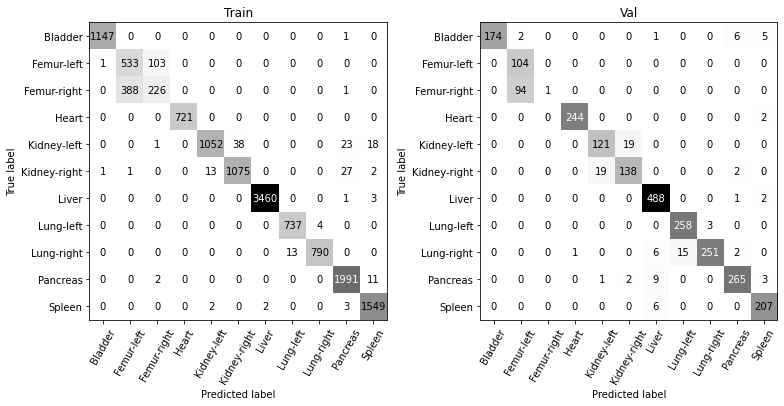

In [30]:
# metricas de desempeño y matriz de confusion
df_ensemble, fig_conf_matr_ensemble = eval_model(ensemble)
fig_conf_matr_ensemble.savefig("figures/conf_matr_ensemble.svg")

df_ensemble_aux = pd.pivot_table(
    df_ensemble.T.reset_index(),
    values="Base",
    index="level_0",
    columns="level_1",
)
df_ensemble_aux.applymap(lambda x: round(x, 3)).loc[["Train", "Val"]].iloc[:, :4]

# Resumen de resultados

In [31]:
df_results = pd.concat(
    [
        df_base,
        df_early_stopping,
        df_big,
        df_data_augmentation,
        df_batch_norm,
        df_ensemble,
    ]
)
df_results.index = [
    "Base",
    "Early Stopping",
    "Big",
    "Data Augmentation",
    "Batch Normalization",
    "Ensemble",
]
df_results.iloc[:, df_results.columns.get_level_values(1) != "support"].applymap(
    lambda x: round(x, 3)
)

Train                                Val            \
                    accuracy precision recall f1-score accuracy precision   
Base                   0.775     0.780  0.775    0.775    0.815     0.825   
Early Stopping         0.809     0.808  0.809    0.798    0.833     0.836   
Big                    0.893     0.902  0.893    0.884    0.862     0.849   
Data Augmentation      0.880     0.883  0.880    0.878    0.891     0.893   
Batch Normalization    0.934     0.934  0.934    0.934    0.903     0.905   
Ensemble               0.953     0.955  0.953    0.951    0.918     0.937   

                                        Test                            
                    recall f1-score accuracy precision recall f1-score  
Base                 0.815    0.812    0.677     0.682  0.677    0.675  
Early Stopping       0.833    0.828    0.683     0.675  0.683    0.669  
Big                  0.862    0.849    0.723     0.725  0.723    0.714  
Data Augmentation    0.891    0.891    0.741     0.742  0.741    0.738  
Batch Normalization  0.903    0.901    0.762     0.763  0.762    0.758  
Ensemble             0.918    0.905    0.813     0.813  0.813    0.809